In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
import torch
from torchvision import datasets, models, transforms
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
import torchvision
import torch.nn.utils.prune as prune

In [2]:
mobilenet_path = "MNV2_weights.h5"

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [4]:
model = torch.load(mobilenet_path,map_location='cpu')

model =torchvision.models.mobilenet_v2(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

model.classifier = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(in_features=1280, out_features=8, bias=True),
            nn.Softmax(dim=1))
model.eval()


eyeGazeClasses = ['Eyes Closed', 'Forward', 'Left Mirror', 'Radio', 
                  'Rearview', 'Right Mirror', 'Shoulder', 'Speedometer']

C:\Users\AS-GP\AppData\Local\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\AS-GP\AppData\Local\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
print(model)

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [ ]:
# print(model.features[18][0])

In [ ]:
parameter_to_prune = (
    (model.features[0][0],"weight"),
    (model.features[1].conv[0][0],"weight"),
    (model.features[2].conv[0][0],"weight"),
    (model.features[3].conv[0][0],"weight"),
    (model.features[4].conv[0][0],"weight"),
    (model.features[5].conv[0][0],"weight"),
    (model.features[6].conv[0][0],"weight"),
    (model.features[18][0],"weight")
)

In [ ]:
prune.global_unstructured(parameter_to_prune, pruning_method = prune.L1Unstructured, amount =0.2,)

In [ ]:
#print("Global sparsity: {:.2f}%".format(100. * float(torch.sum(model.conv1.weight == 0)+ torch.sum(model.conv2.weight == 0)+ torch.sum(model.fc1.weight == 0)+ torch.sum(model.fc2.weight == 0)+ torch.sum(model.fc3.weight == 0))/ float(model.conv1.weight.nelement()+ model.conv2.weight.nelement()+ model.fc1.weight.nelement()+ model.fc2.weight.nelement()+ model.fc3.weight.nelement(
# 


In [ ]:
# print(model.features[5].conv[0][0].weight)

In [ ]:
# for element in model.features[5].conv[0][0].weight:
#     print (element[0])

In [6]:
input_path='C:/Users/AS-GP/Desktop/Resnet50/lisat_gaze_data_v1/'

In [7]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

data_transforms = {
    'train':
    transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize
    ]),
    'validation':
    transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(), #for parallel computations
        normalize
    ]),
}

#train_subset_size = int(0.4 * len(datasets.ImageFolder(input_path + 'train_1250', transform=data_transforms['train']))) #testing hashelha b3den

image_datasets = {
    'train':
    datasets.ImageFolder(input_path + 'new/train', data_transforms['train']),
    'validation':
    datasets.ImageFolder(input_path + 'new/val', data_transforms['validation'])
}

dataloaders = {
    'train':
    torch.utils.data.DataLoader(image_datasets['train'],
                                batch_size=32,
                                shuffle=True,
                                num_workers=2),  # for now 2
    'validation':
    torch.utils.data.DataLoader(image_datasets['validation'],
                                batch_size=32,
                                shuffle=False,
                                num_workers=2)  # for Kaggle
}


In [8]:
print("Train dataset size:", len(image_datasets['train']))
print("Validation dataset size:", len(image_datasets['validation']))

Train dataset size: 28763
Validation dataset size: 10766


In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [12]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(model, dataloader, num_classes, class_labels):
    # Set the model to evaluation mode
    model.eval()

    # Initialize lists to store the true and predicted labels
    true_labels = []
    pred_labels = []

    # Move the model to the GPU (cuda:0)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Iterate over the validation dataset
    with torch.no_grad():
        for images, labels in dataloader:
            # Move the input tensor to the same device as the model weights
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)

            # Get the predicted labels
            _, predicted = torch.max(outputs.data, 1)

            # Store the true and predicted labels
            true_labels += labels.cpu().numpy().tolist()
            pred_labels += predicted.cpu().numpy().tolist()

    # Compute the confusion matrix
    cm = confusion_matrix(true_labels, pred_labels)

    # Plot the confusion matrix
    plt.figure(figsize=(10, 8))
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.imshow(cm, cmap='Blues')
    plt.xticks(range(num_classes), class_labels)
    plt.yticks(range(num_classes), class_labels)
    cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)
    plt.colorbar()
    plt.clim(0, max(cm.max(), cm.sum()))
    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        color = "white" if cm[i, j] > thresh else "black"
        plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)

    plt.tight_layout()
    plt.ylim(num_classes, -0.5)
    plt.imshow(cm, cmap='Blues', vmin=0, vmax=1)
    plt.show()

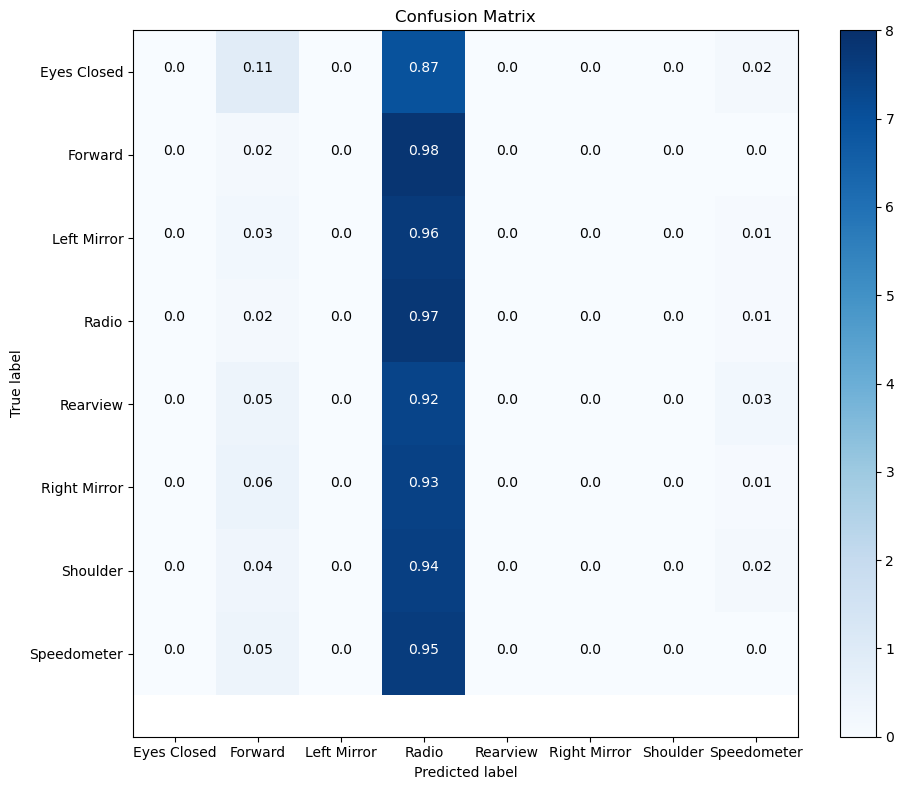

In [13]:
plot_confusion_matrix(model,dataloaders['validation'],8,eyeGazeClasses)